# NEW YORK CITY TAXI FARES (NYCTF)

## Project imports, folders and variables

### General imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from math import *

#pyplot
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#dealing with folder paths
import os
import sys

#serialisation and compression
import pickle

#refreshing modules imports
from importlib import reload

# from francois import babyfoot_cheat_engine

Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/env35/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['hypot', 'cos', 'e', 'log', 'inf', 'tan', 'trunc', 'frexp', 'copysign', 'log2', 'cosh', 'log10', 'isfinite', 'fmod', 'modf', 'log1p', 'ceil', 'nan', 'isnan', 'sinh', 'isinf', 'sqrt', 'ldexp', 'tanh', 'sin', 'expm1', 'isclose', 'gamma', 'exp', 'gcd', 'floor', 'pi', 'fabs', 'radians', 'degrees']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Folder paths

In [2]:
projectDir = os.path.join(os.getcwd(), os.pardir, os.pardir)
#notebook is in "NYCTF/notebooks/exploratory" or "NYCTF/notebooks/reports": this actually links to NYCTF

srcDir = os.path.join(projectDir, 'src')
sys.path.append(srcDir) #adds src to search path for modules

dataDir = os.path.join(projectDir, 'data')
pickleDir = os.path.join(dataDir, 'processed/pickle')

### Modules imports

In [4]:
import NYCTF_data_preparation as dp; reload(dp);
import NYCTF_geo as geo; reload(geo);

### Variables

In [5]:
b_usePickleFiles = True
#True should you want to use the data stored using pickle
#False should you want to (re)generate the data from scratch

b_dataPrepared = True
#True if the loaded data are already prepared
#False if the loaded data are raw

readcsvParseDates = False
#only matters if usePickleFiles is set to False
#["pickup_datetime"] should you want to parse dates when reading the csv file
#False shoud you want to do it later (manually)

minmaxCoordinates = [40, 42, -75, -71] #[latitudeMin, latitudeMax, longitudeMin, longitudeMax]
#needs some more exploration and thinking. will change for min max in test set

colTypes = {'fare_amount': 'float32', #tried float16 but then you cannot calculate the mean and std
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'}

distUnit = 'km'
rEarth = 6371 #radius of the Earth in dist_unit

## Data loading & preparation

### Get number of lines in the csv files (if loading from csv)

In [6]:
%%time

#choose method among 'unixwc' and 'readlines'. 'readlines' (resp. 'unixwc') faster for short (resp. long) files
method = 'readlines'

if not b_usePickleFiles:
    trainRowCount = dp.row_count(os.path.join(dataDir, 'raw/train.csv'), method)
    testRowCount = dp.row_count(os.path.join(dataDir, 'raw/test.csv'), method)
    print('Number of lines in train file: ' + str(trainRowCount))
    print('Number of lines in test file: ' + str(testRowCount))
else:
    print('Training and test datasets will not come from .csv files.')

Training and test datasets will not come from .csv files.
CPU times: user 181 µs, sys: 168 µs, total: 349 µs
Wall time: 239 µs


### Load the data (from csv or pickle files)

In [7]:
%%time
if b_usePickleFiles:
    if b_dataPrepared:
        with open(os.path.join(dataDir, 'processed/pickle/trainPrep.pickle'), 'rb') as f:
            dfTrainPrep = pickle.load(f)
        with open(os.path.join(dataDir, 'processed/pickle/testPrep.pickle'), 'rb') as f:
            dfTestPrep = pickle.load(f)
    else:
        with open(os.path.join(dataDir, 'processed/pickle/train.pickle'), 'rb') as f:
            dfTrain = pickle.load(f)
        with open(os.path.join(dataDir, 'processed/pickle/test.pickle'), 'rb') as f:
            dfTest = pickle.load(f)
else:
    dfTrain = pd.read_csv(os.path.join(dataDir, 'raw/train.csv'), parse_dates=readcsvParseDates)
    dfTest = pd.read_csv(os.path.join(dataDir, 'raw/test.csv'), parse_dates=readcsvParseDates)
    with open(os.path.join(dataDir, 'processed/pickle/train.pickle'), 'wb') as f:
        pickle.dump(dfTrain, f)
    with open(os.path.join(dataDir, 'processed/pickle/test.pickle'), 'wb') as f:
        pickle.dump(dfTest, f)

CPU times: user 7.23 s, sys: 5.06 s, total: 12.3 s
Wall time: 14.1 s


### Data preparation

In [8]:
%%time
if not b_dataPrepared:
    dfTestPrep = dp.prepare_data(dfTest, 'test', colTypes, readcsvParseDates==False, True, pickleDir, 'testPrep.pickle')
    print(dfTestPrep.info())
else:
    print('Data already prepared.')

Data already prepared.
CPU times: user 68 µs, sys: 50 µs, total: 118 µs
Wall time: 112 µs


In [57]:
%%time
if not b_dataPrepared:
    dfTrainPrep = dp.prepare_data(dfTrain, 'Train', colTypes, readcsvParseDates==False, True, pickleDir, 'trainPrep.pickle')
    print(dfTrainPrep.info())
else:
    print('Data already prepared.')

Train
Step 1/6 complete.
Step 2/6 complete. Incomplete rows have been removed.
Step 3/6 complete. Types changed to more relevant ones.
Step 4/6 complete. Dates have been parsed.
Step 5/6 complete. Records with negative or >=$1000 fares have been removed.
Step 6/6 completed. Prepared dataframe has been saved in a pickle file.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 55419634 entries, 0 to 55423855
Data columns (total 8 columns):
key                  object
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, UTC](1), float32(5), object(1), uint8(1)
memory usage: 2.3+ GB
None
CPU times: user 1min 30s, sys: 21.4 s, total: 1min 51s
Wall time: 2min 2s


## Geo (cleaning + first ideas)

### Cleaning

In [9]:
%%time
#Remove outlying coordinates
dfTrainPrep = geo.removeOutlyingCoordinates(dfTrainPrep, minmaxCoordinates)

CPU times: user 2.63 s, sys: 1.87 s, total: 4.5 s
Wall time: 4.5 s


### Adding a 'distance' feature

First method is flying distance.
Second method consists of rotating the map of Manhattan then using the 1-distance.
Third method consists of using Google Maps (or similar) - the itinerary may however not be the one the taxi driver actually took.

In [74]:
dfTrainPrep_sample = dfTrainPrep.head(5)

In [75]:
print(dfTrainPrep_sample)

                             key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:00+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:00+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:00+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844315        40.721317         -73.841614         40.712276   
1        -74.016045        40.711304         -73.979271         40.782005   
2        -73.982735        40.761269         -73.991241         40.750561   
3        -73.987129        40.733143         -73.991570         40.758091   
4        -73.968094        40.768009         -73.956657         40.783764   

   passenger_count  
0                1  
1                1  
2                2  
3 

#### Flying distance

In [76]:
dfTrainPrep_sample = geo.add_flying_distance(dfTrainPrep_sample, 'deg', rEarth, distUnit)
print(dfTrainPrep_sample)

                             key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:00+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:00+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:00+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844315        40.721317         -73.841614         40.712276   
1        -74.016045        40.711304         -73.979271         40.782005   
2        -73.982735        40.761269         -73.991241         40.750561   
3        -73.987129        40.733143         -73.991570         40.758091   
4        -73.968094        40.768009         -73.956657         40.783764   

   passenger_count  flying_distance_km  
0                1            1.030742  
1   

#### L1-distance

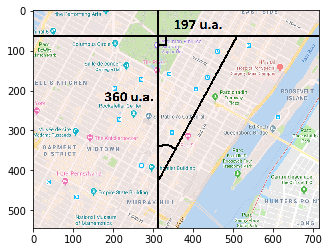

Angle: 0.5007080588399464 rad = 28.68845853971702°.


In [77]:
#Calculating the angle that the Manhattan street grid is rotated from the north-south axis
#https://www.nytimes.com/2006/07/02/nyregion/thecity/02grid.html quotes 29°. let's check this.
img=mpimg.imread(os.path.join(dataDir, 'processed/images/Manhattan_street_angle.png'))
imgplot = plt.imshow(img)
plt.show()

lMan = 197
hMan = 360
angMan = atan(lMan/hMan) #(rad)
print('Angle: ' + str(angMan) +' rad = ' + str(angMan*180/pi) + '°.')

In [78]:
dfTrainPrep_sample = geo.add_L1_distance(dfTrainPrep_sample, 'deg', rEarth, distUnit, angMan) #plane_rot_angle in rad please

In [79]:
print(dfTrainPrep_sample)

                             key  fare_amount           pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:00+00:00   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:00+00:00   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00+00:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:00+00:00   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00+00:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844315        40.721317         -73.841614         40.712276   
1        -74.016045        40.711304         -73.979271         40.782005   
2        -73.982735        40.761269         -73.991241         40.750561   
3        -73.987129        40.733143         -73.991570         40.758091   
4        -73.968094        40.768009         -73.956657         40.783764   

   passenger_count  flying_distance_km  L1_distance_km  
0                1           

### Geographical clusters?

In [38]:
#1 cluster would be, for example, the JFK airport, or a "neighbourhood" in NYC (maybe not the official ones, can be customised/calculated zones)

## Time (first ideas)

In [30]:
#Time clusters / geo-time clusters / time-related features?

#weekday/WE, night, rushhour, before/after 201X when they changed the fares...: all those that impact the fare directly through surchages
#these should not be geo-dependent

#some other time-related paramaters/clusters might be geo-dependent (id est impact the traffic situation)

#---
#Estimate the duration of the trip?

#---
#Open data...?

#Weather data, traffic data...?
